# Setup

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import chisquare
from scipy.stats import multinomial
from scipy.stats import kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd

pastel_colors = sns.color_palette("pastel", 3)
sns.set(style="whitegrid")

condition_order = ["Stroke", "Tap", "Vibration"]
condition_palette = {
    "Stroke": pastel_colors[0],  # First color in the pastel palette
    "Tap": pastel_colors[1],     # Second color in the pastel palette
    "Vibration": pastel_colors[2]  # Third color in the pastel palette
}

# Define the sequence of characters
character_order = ['T', 'H', 'E', 'O', 'L', 'D', 'P', 'U', 'B']

participant_data = pd.read_csv("study1data.csv")


# ClickCounts

### Plot the click counts of the participants

In [ ]:
def extract_clicks_data(df:pd.DataFrame) -> pd.DataFrame():
  """
  Extracts and orders the 'Clicks' data for each participant based on the defined character sequence.

  Parameters:
      df (pd.DataFrame): The input DataFrame containing click data for different characters.

  Returns:
      pd.DataFrame: A DataFrame containing ordered click data for each character.
  """
  clicks_ordered_df = pd.DataFrame()
  for char in character_order:
      clicks_ordered_df[char] = df[f'{char} Clicks']
  return clicks_ordered_df

def plot_participant_clicks(axes, index:int, row:int):
  """
  Plots the click data for a single participant.

  Parameters:
      axes (matplotlib.axes.Axes): The array of axes for plotting.
      index (int): The index of the participant in the dataset.
      row (pd.Series): A Pandas Series containing the click data for the participant.

  Returns:
      None
  """
  axes[index].plot(character_order, row, marker='o', linestyle='-', markersize=6, color=pastel_colors[0], label='Original Clicks')

  line_1_4, line_0_6 = [None], [None]
  for j in range(1, len(character_order)):
      previous_value = row[character_order[j - 1]]
      line_1_4.append(previous_value * 1.4)
      line_0_6.append(previous_value * 0.6)

  axes[index].plot(character_order[1:], line_1_4[1:], linestyle='-', marker='o', markersize=6, color=pastel_colors[1], label='1.4x Previous')
  axes[index].plot(character_order[1:], line_0_6[1:], linestyle='-', marker='o', markersize=6, color=pastel_colors[1], label='0.6x Previous')
  axes[index].set_title(f'Participant {index + 1}', fontsize=14)
  axes[index].set_xlabel('Character', fontsize=12)
  axes[index].set_ylabel('Number of Clicks', fontsize=12)
  axes[index].set_xticks(character_order)
  axes[index].tick_params(axis='x', rotation=45)
  axes[index].grid(True)
  axes[index].set_yscale('log')
  axes[index].set_ylim(bottom=10)
  axes[index].legend()

def generate_plots(df, pdf_name):
  """
  Generates and saves plots for participant click data.

  Parameters:
      df (pd.DataFrame): The DataFrame containing participant click data.
      pdf_name (str): The name of the PDF file to save the plots.

  Returns:
      None
  """
  clicks_ordered_df = extract_clicks_data(df)
  num_participants = len(df)
  fig, axes = plt.subplots(num_participants, 1, figsize=(12, 3 * num_participants))
  if num_participants == 1:
      axes = [axes]

  pastel_colors = sns.color_palette("pastel", 3)
  for i, row in clicks_ordered_df.iterrows():
      plot_participant_clicks(axes, i, row)

  plt.tight_layout()
  plt.subplots_adjust(hspace=0.5)
  plt.savefig(f'/content/{pdf_name}.pdf', format='pdf')

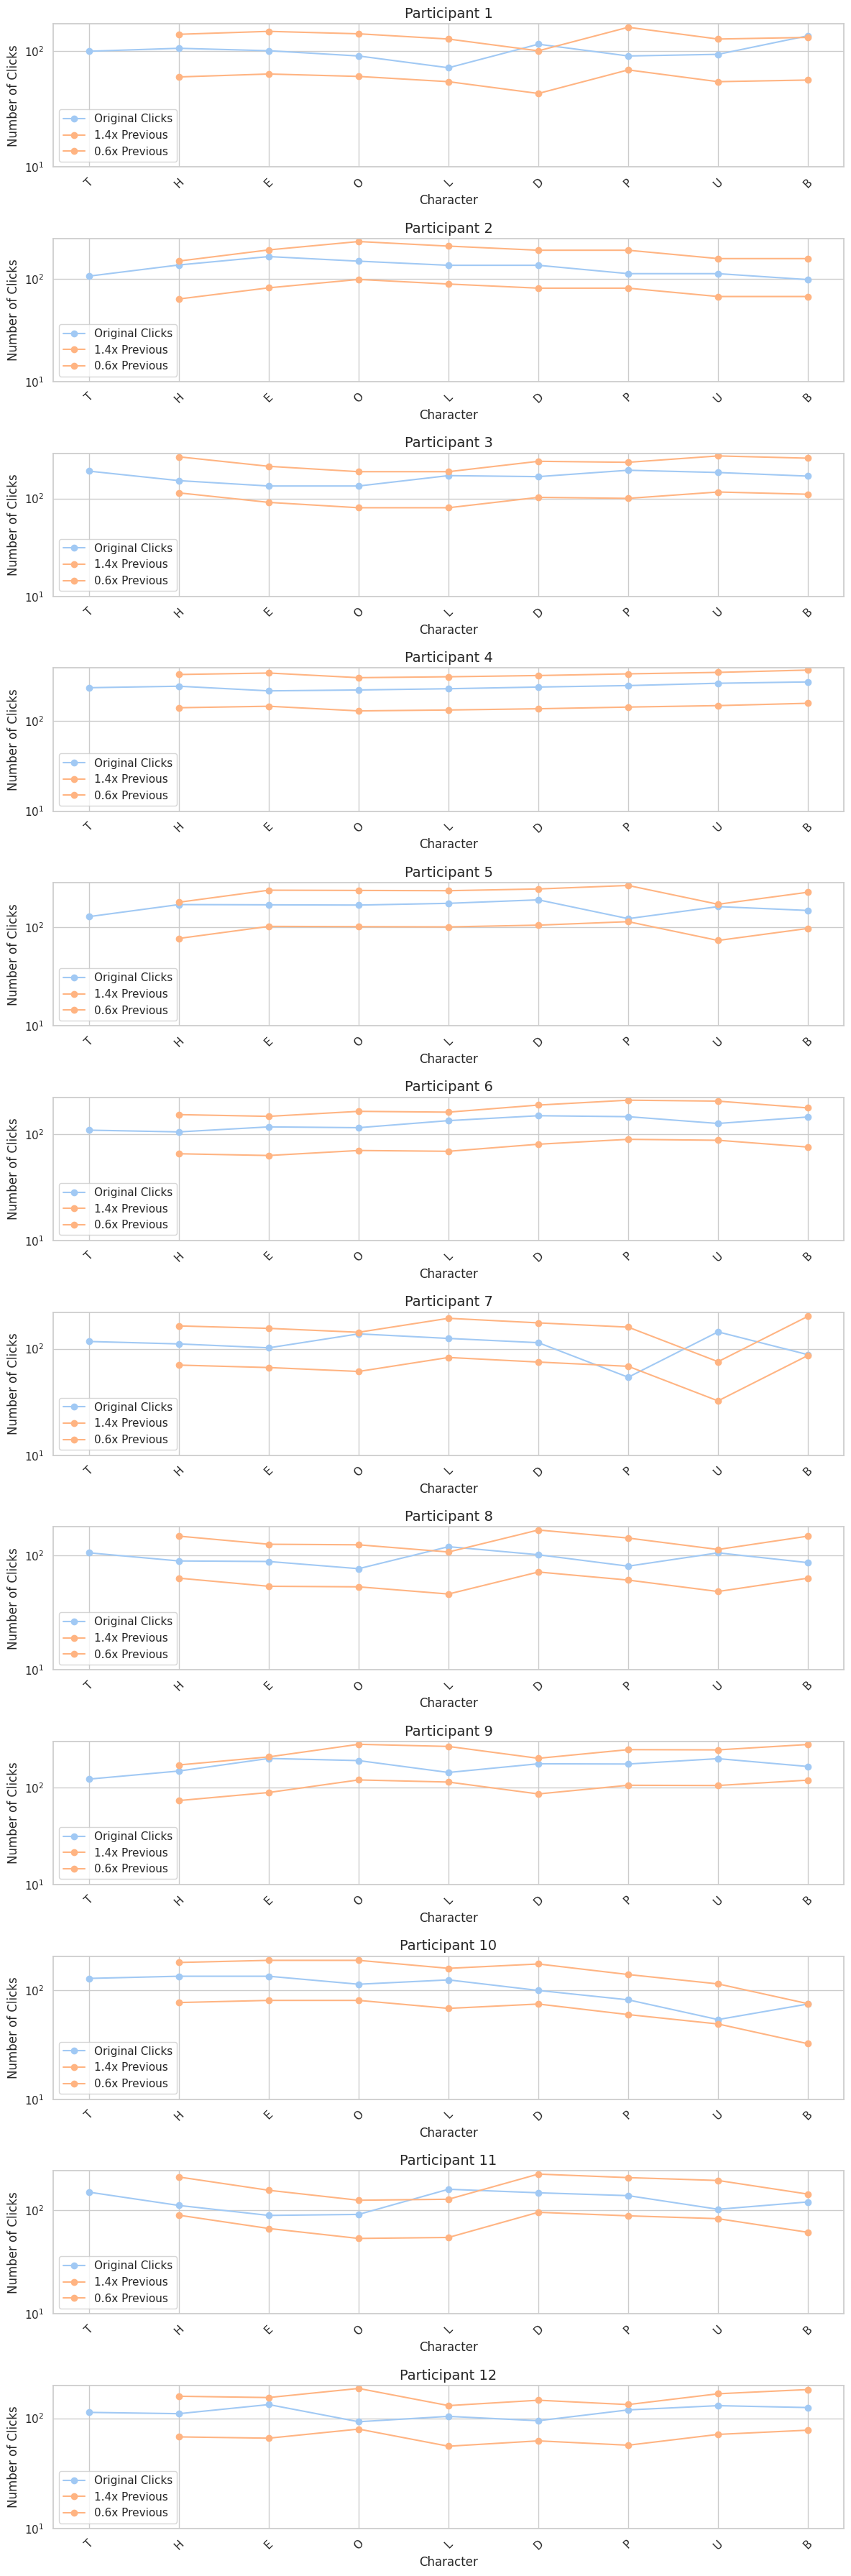

In [ ]:
generate_plots(participant_data.copy(), "participantPlots")

# Conduct NasaTLX tests

In [ ]:
def perform_levene_test(data1:pd.DataFrame, data2:pd.DataFrame, data3:pd.DataFrame)->float:
  """
    Performs Levene's Test to assess the homogeneity of variances between three datasets.

    Parameters:
        data1 (pd.DataFrame): The first dataset.
        data2 (pd.DataFrame): The second dataset.
        data3 (pd.DataFrame): The third dataset.

    Returns:
        float: The p-value from Levene's Test, indicating whether the variance assumption is met.
    """
  statistic, p_value = stats.levene(data1, data2, data3)
  if p_value >= 0.05:
      print(f"Levene's Test: The variances are equal (homogeneity of variances assumption is met).\nWith p_value: {p_value:.4f} and statistic: {statistic}")
  else:
      print(f"Levene's Test: The variances are significantly different (homogeneity of variances assumption is violated).\nWith p_value: {p_value:.4f} and statistic: {statistic}")
  return p_value


def perform_shapiro_test(data:pd.DataFrame, condition:str)->float:
  """
  Performs the Shapiro-Wilk Test to check for normality in the given dataset.

  Parameters:
      data (pd.DataFrame): The dataset to be tested for normality.
      condition (str): The condition label for the dataset.

  Returns:
      float: The p-value from the Shapiro-Wilk Test, indicating whether the data follows a normal distribution.
  """
  stat, p_value = stats.shapiro(data)
  if p_value >= 0.05:
      print(f"Shapiro-Wilk Test: The {condition} data is normally distributed (p-value = {p_value:.4f}).")
  else:
      print(f"Shapiro-Wilk Test: The {condition} data is not normally distributed (p-value = {p_value:.4f}).")
  return p_value


def perform_tests(question_data:pd.DataFrame, question:str):
  """
  Conducts statistical tests to check for homogeneity of variance and normality in the dataset.

  This function performs Levene's Test for variance homogeneity, the Shapiro-Wilk Test for normality,
  and Kruskal-Wallis Test for differences between conditions. If the Kruskal-Wallis Test is significant,
  a post-hoc analysis is performed.

  Parameters:
      question_data (pd.DataFrame): The dataset containing the question responses and conditions.
      question (str): The column name representing the question being analyzed.

  Returns:
      None
  """
  conditions_data = [question_data[question_data['Condition'] == condition][question].values for condition in question_data['Condition'].unique()]

  p_value_levene = perform_levene_test(*conditions_data)
  normality_results = {condition: perform_shapiro_test(question_data[question_data['Condition'] == condition][question].values, condition)
                        for condition in question_data['Condition'].unique()}

  H, p_value_kruskal, k, N = perform_kruskal_wallis(conditions_data, question)
  calculate_eta_squared(H, N)

  if p_value_kruskal < 0.05:
      perform_posthoc_analysis(question_data, question)


def plot_nasa_tlx_results(data:pd.DataFrame, questions:list, subtitle:str, limit:int, pdf_name:str):
    """
    Plot NASA TLX results as box plots for each question, comparing the conditions (T, S, V) in one plot.
    Also, perform an ANOVA test on each question to check for significant differences between conditions.
    If ANOVA is significant, perform post-hoc tests for pairwise comparisons.

    Parameters:
        data (pd.DataFrame): DataFrame containing NASA TLX results.
        questions (list): List of NASA TLX question labels (e.g., "Mental Demand", "Physical Demand").
        subtitle (str): Subtitle for the plot.
        limit (int): Limit for the y-axis (e.g., 100).
    """
    plt.figure(figsize=(15, 6))

    for i, question in enumerate(questions):
        question_data = prepare_question_data(data, question)

        print_medians(question_data, question)
        perform_tests(question_data, question)

        create_boxplot_and_swarmplot(question_data, question, i, len(questions), limit)
        print("\n\n")

    plt.tight_layout()
    plt.suptitle(subtitle, y=1.05, fontsize=14)  # Subtitle at the top
    plt.savefig(f'/content/{pdf_name}.pdf', format='pdf')


def prepare_question_data(data:pd.DataFrame, question:str)->pd.DataFrame:
    """
    Prepare the data for a given NASA TLX question by reshaping and performing ANOVA.
    This function returns the reshaped data and the p-value from the ANOVA test.

    Parameters:
        data (pd.DataFrame): DataFrame containing NASA TLX results.
        question (str): The NASA TLX question label.

    Returns:
        question_data (pd.DataFrame): Melted data frame for the question.
        p_value (float): p-value from the ANOVA test.
    """
    relevant_columns = [f"T {question}", f"S {question}", f"V {question}"]

    missing_columns = [col for col in relevant_columns if col not in data.columns]
    if missing_columns:
        print(f"Warning: Missing columns for question '{question}': {', '.join(missing_columns)}")
        return None, None

    question_data = data[relevant_columns].melt(var_name="Condition", value_name=question)
    question_data['Condition'] = question_data['Condition'].map({
        f"T {question}": 'Tap',
        f"S {question}": 'Stroke',
        f"V {question}": 'Vibration'
    })
    return question_data

def perform_kruskal_wallis(conditions_data:list, question:str)->tuple:
  """
    Performs the Kruskal-Wallis H test to compare multiple independent groups.

    Parameters:
        conditions_data (list): A list of datasets, each representing a condition's data.
        question (str): The question being analyzed.

    Returns:
        tuple: A tuple containing:
            - H (float): The Kruskal-Wallis test statistic.
            - p_value (float): The p-value indicating whether there is a significant difference.
            - k (int): The number of groups.
            - N (int): The total number of observations across all groups.
  """
  groups = [data for data in conditions_data]
  H, p_value = kruskal(*groups)
  print(f"Kruskal-Wallis result for '{question}': p-value = {p_value:.4f}")
  if p_value < 0.05:
      print(f"  * Significant difference found for '{question}' between conditions.\nWith h_stat: {H:.4f}, p_value: {p_value:.4f}")
  else:
      print(f"  * No significant difference found for '{question}' between conditions.\nWith h_stat: {H:.4f}, p_value: {p_value:.4f}")
  return H, p_value, len(groups), sum(len(group) for group in groups)  # Return H, p_value, k, N


def calculate_eta_squared(H, N):
  """
    Calculates the effect size (Eta-Squared) for the Kruskal-Wallis test.

    Parameters:
        H (float): The Kruskal-Wallis test statistic.
        N (int): The total number of observations.

    Returns:
        None
  """
  eta_squared = H / (N - 1)
  print(f"\tEffect Size (Eta-Squared): {eta_squared:.4f}")


def perform_anova(data:pd.DataFrame, question:str)->float:
  """
  Perform an ANOVA test to check for significant differences between conditions.

  Parameters:
      test_data (pd.DataFrame): Data for the current test.
      score (str): The score column to perform ANOVA on.

  Returns:
      float: The p-value from the ANOVA test.
  """
  f_stat, p_value = stats.f_oneway(*data)
  print(f"ANOVA result for '{question}': p-value = {p_value:.4f}")
  if p_value < 0.05:
      print(f"  * Significant difference found for '{question}' between conditions.\n\tWith f_stat: {f_stat:.4f}, p_value: {p_value}:.4f")
  else:
      print(f"  * No significant difference found for '{question}' between conditions.\n\tWith f_stat: {f_stat:.4f}, p_value: {p_value:.4f}")
  return p_value


def print_medians(question_data:pd.DataFrame, question:str):
  """
  Print the median for each condition in the current question.

  Parameters:
      question_data (pd.DataFrame): The melted data frame for the question.
      question (str): The NASA TLX question label.
  """
  print(f"Medians for '{question}':")
  for condition in question_data['Condition'].unique():
      condition_data = question_data[question_data['Condition'] == condition]
      median = condition_data[question].median()
      print(f"  {condition}: {median:.4f}")


def perform_posthoc_analysis(question_data:pd.DataFrame, question:str):
  """
  Perform post-hoc pairwise comparisons using Tukey's HSD test if ANOVA is significant.

  Parameters:
      question_data (pd.DataFrame): The melted data frame for the question.
      question (str): The NASA TLX question label.
  """
  tukey_results = pairwise_tukeyhsd(
      question_data[question],
      question_data['Condition'],
      alpha=0.05
  )
  print(tukey_results.summary())


def create_boxplot_and_swarmplot(question_data:pd.DataFrame, question:str, i:int, num_questions:int, limit:int):
  """
  Create a boxplot for the given NASA TLX question and its data, overlaid with a swarm plot.

  Parameters:
      question_data (pd.DataFrame): The melted data frame for the question.
      question (str): The NASA TLX question label.
      i (int): The index of the current question in the plot grid.
      num_questions (int): Total number of questions being plotted.
      limit (int): Limit for the y-axis (e.g., 100).
  """
  plt.subplot(1, num_questions, i + 1)

  sns.boxplot(
      x='Condition',  # Group by 'Condition' (T, S, V)
      y=question,  # Plot the current question's values
      data=question_data,  # Use the melted data frame
      showfliers=False,  # Hide outliers in the box plot
      linewidth=1,
      dodge=False,  # Keep all conditions in the same plot
      hue='Condition',  # Explicitly assign 'Condition' to hue
      palette=condition_palette,
      order=condition_order,
      medianprops={'color': '#6E6E6E', 'linewidth': 2}
  )

  # Overlay the swarm plot for the current question (show individual points)
  sns.swarmplot(
      x='Condition',  # Group by 'Condition'
      y=question,  # Plot the current question's values
      data=question_data,  # Use the melted data frame
      color='k',  # Color of the individual data points (black)
      size=3,  # Size of the points
      alpha=0.6,  # Transparency of the points
      dodge=False,  # Keep all points in the same plot
  )

  title = question if len(question) < 20 else " ".join(map(str, question.split()[0:4])) + "\n" + " ".join(map(str, question.split()[4:]))
  plt.title(title, fontsize=12)
  plt.xlabel('Stimulus')
  ylabel_value = 'Score' if i == 0 else ''
  plt.ylabel(ylabel_value)
  plt.ylim(0, limit)
  plt.xticks(fontsize=8)


def create_boxplot(question_data:pd.DataFrame, question:str, i:int, num_questions:int, limit:int):
  """
  Create a boxplot for the given NASA TLX question and its data.

  Parameters:
      question_data (pd.DataFrame): The melted data frame for the question.
      question (str): The NASA TLX question label.
      i (int): The index of the current question in the plot grid.
      num_questions (int): Total number of questions being plotted.
      limit (int): Limit for the y-axis (e.g., 100).
  """
  plt.subplot(1, num_questions, i + 1)

  sns.boxplot(
      x='Condition',  # Group by 'Condition' (T, S, V)
      y=question,  # Plot the current question's values
      data=question_data,  # Use the melted data frame
      showfliers=False,  # Hide outliers
      linewidth=1,
      dodge=False,  # Keep all conditions in the same plot
      hue='Condition',  # Explicitly assign 'Condition' to hue
      palette=condition_palette,
      order=condition_order,
  )
  title = question if len(question) < 20 else " ".join(map(str, question.split()[0:4])) + "\n" + " ".join(map(str, question.split()[4:]))

  plt.title(title, fontsize=12)
  plt.xlabel('Stimulus')  # Label for x-axis
  ylabel_value = 'Score' if i == 0 else ''
  plt.ylabel(ylabel_value)
  plt.ylim(0, limit)
  plt.xticks(fontsize=8)

Medians for 'Mental Demand':
  Tap: 45.0000
  Stroke: 37.5000
  Vibration: 47.5000
Levene's Test: The variances are equal (homogeneity of variances assumption is met).
With p_value: 0.9324 and statistic: 0.07013450452923413
Shapiro-Wilk Test: The Tap data is normally distributed (p-value = 0.2837).
Shapiro-Wilk Test: The Stroke data is normally distributed (p-value = 0.1796).
Shapiro-Wilk Test: The Vibration data is normally distributed (p-value = 0.7213).
Kruskal-Wallis result for 'Mental Demand': p-value = 0.7668
  * No significant difference found for 'Mental Demand' between conditions.
With h_stat: 0.5311, p_value: 0.7668
	Effect Size (Eta-Squared): 0.0152



Medians for 'Physical Demand':
  Tap: 20.0000
  Stroke: 20.0000
  Vibration: 15.0000
Levene's Test: The variances are equal (homogeneity of variances assumption is met).
With p_value: 0.8791 and statistic: 0.1294117647058823
Shapiro-Wilk Test: The Tap data is normally distributed (p-value = 0.1766).
Shapiro-Wilk Test: The Stro

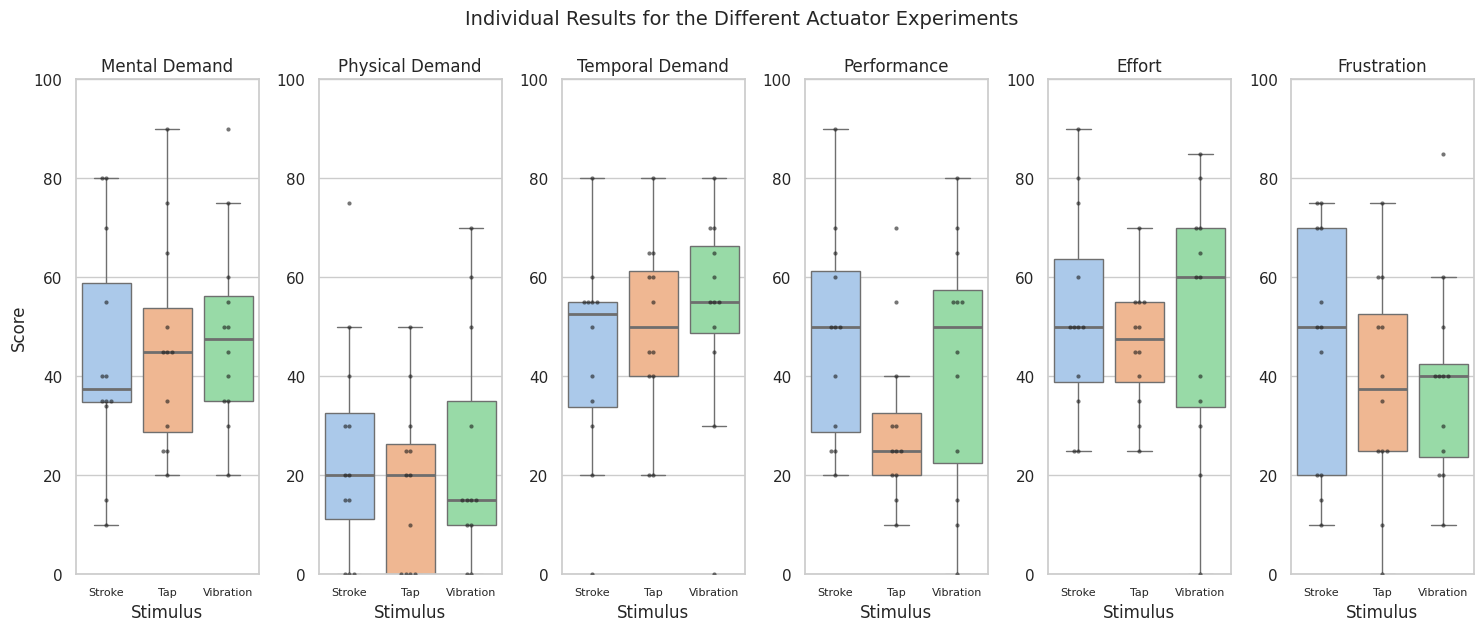

In [ ]:
questions = [
    "Mental Demand",
    "Physical Demand",
    "Temporal Demand",
    "Performance",
    "Effort",
    "Frustration"
]
plot_nasa_tlx_results(participant_data.copy(), questions, "Individual Results for the Different Actuator Experiments", 100, "NasaTLX")

Medians for 'Feeling Pleasant':
  Tap: 3.0000
  Stroke: 4.0000
  Vibration: 3.0000
Levene's Test: The variances are equal (homogeneity of variances assumption is met).
With p_value: 0.9597 and statistic: 0.041198501872659096
Shapiro-Wilk Test: The Tap data is not normally distributed (p-value = 0.0018).
Shapiro-Wilk Test: The Stroke data is not normally distributed (p-value = 0.0005).
Shapiro-Wilk Test: The Vibration data is not normally distributed (p-value = 0.0113).
Kruskal-Wallis result for 'Feeling Pleasant': p-value = 0.7026
  * No significant difference found for 'Feeling Pleasant' between conditions.
With h_stat: 0.7060, p_value: 0.7026
	Effect Size (Eta-Squared): 0.0202



Medians for 'Helped Learning':
  Tap: 3.0000
  Stroke: 3.0000
  Vibration: 3.0000
Levene's Test: The variances are equal (homogeneity of variances assumption is met).
With p_value: 0.5116 and statistic: 0.6839378238341968
Shapiro-Wilk Test: The Tap data is not normally distributed (p-value = 0.0275).
Shapiro

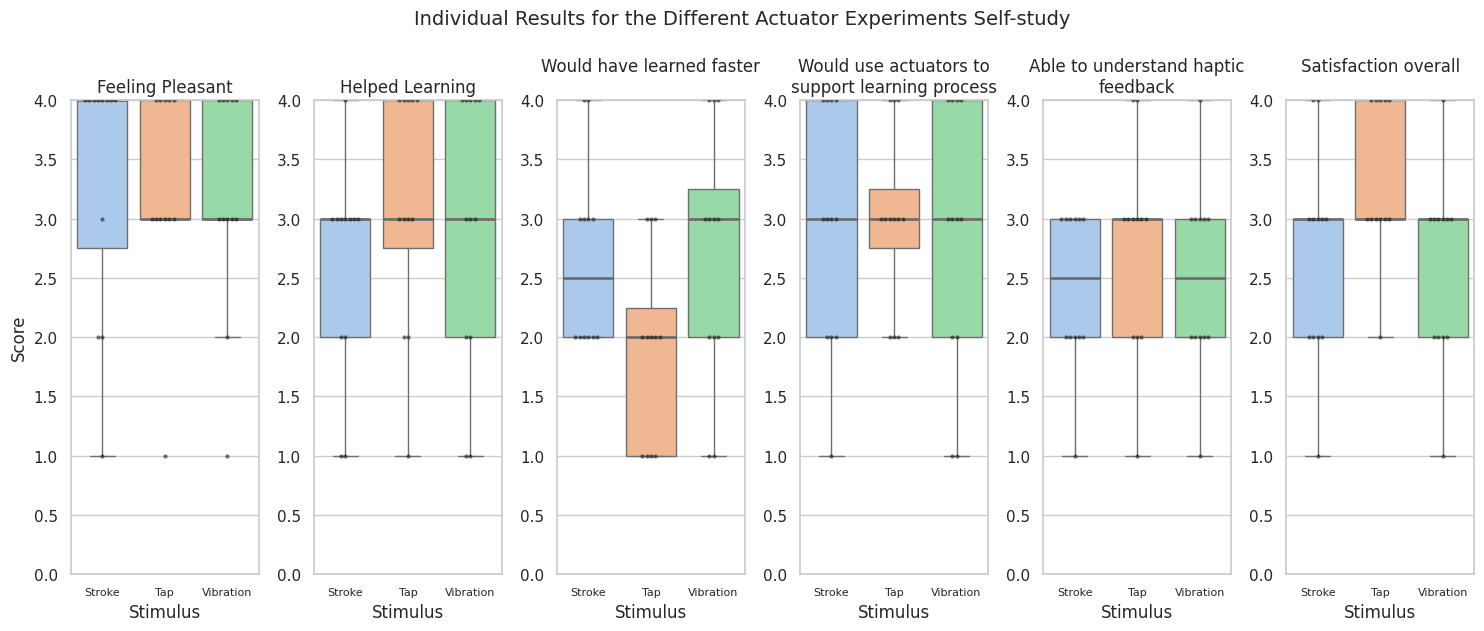

In [ ]:
questions = [
    "Feeling Pleasant",
    "Helped Learning",
    "Would have learned faster",
    "Would use actuators to support learning process",
    "Able to understand haptic feedback",
    "Satisfaction overall"
]
plot_nasa_tlx_results(participant_data.copy(), questions, "Individual Results for the Different Actuator Experiments Self-study", 4, "self_assessment")

# Direct comparisson

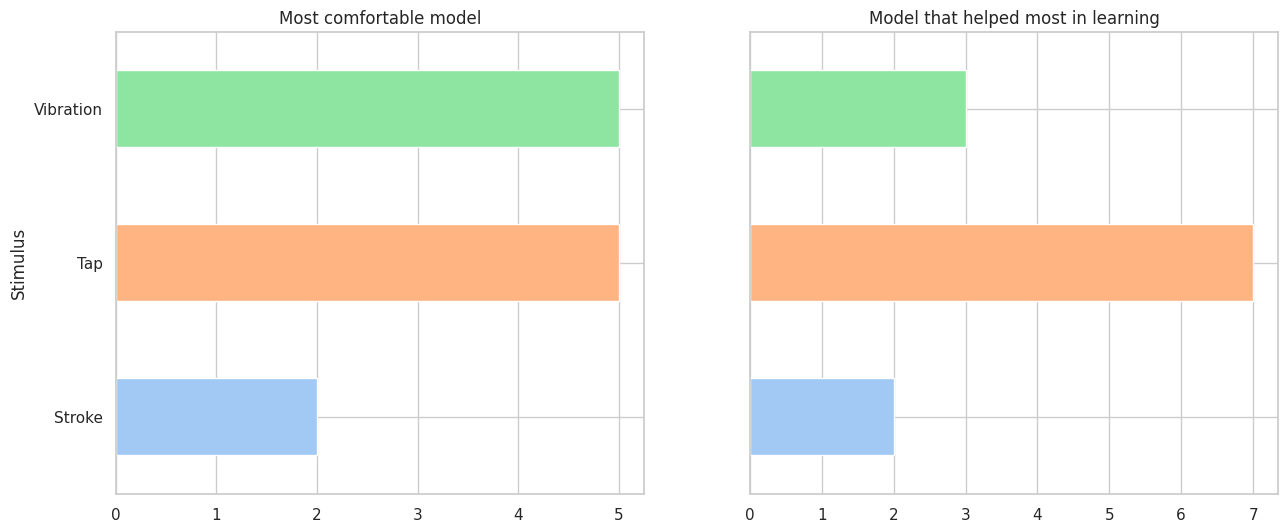

In [ ]:
def createBarplotComparisson(columns:list, titles:list, data:pd.DataFrame):
  """
    Creates and saves a side-by-side horizontal bar plot comparing two data columns.

    Parameters:
        columns (list): A list containing two column names to be compared.
        titles (list): A list of two titles for the respective bar plots.
        data (pd.DataFrame): The dataset containing the columns to be plotted.

    Returns:
        None
    """
  fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
  group_columns = columns

  for ax, col, title in zip(axes, group_columns, titles):
      unique_conditions = dataframe[col].unique()
      unique_conditions_sorted = [condition for condition in condition_order if condition in unique_conditions]

      bar_colors = [condition_palette[condition] for condition in unique_conditions_sorted]
      dataframe.groupby(col).size().loc[unique_conditions_sorted].plot(kind='barh', color=bar_colors, ax=ax)

      ax.set_title(title)
      ax.spines[['top', 'right']].set_visible(True)
      ax.set_ylabel('Stimulus')
  plt.savefig(f'/content/{titles}.pdf', format='pdf')




dataframe = participant_data[["Model most comfortable","Model that helped most in learning"]].copy()
dataframe.replace({"T": "Tap", "S": "Stroke", "V": "Vibration"}, inplace=True)
columns = ["Model most comfortable","Model that helped most in learning"]
titles = ["Most comfortable model","Model that helped most in learning"]

createBarplotComparisson(columns, titles, dataframe)

### Conduct statistical tests

In [ ]:
import numpy as np
from scipy.stats import chisquare
from scipy.stats import multinomial

def multinomial_goodness_of_fit_test(observed:list, total:int, num_simulations:int=10000)->tuple:
    """
    Performs an exact multinomial goodness-of-fit test using a Monte Carlo method.

    Parameters:
        observed (list): Observed frequencies.
        total (int): Total number of observations.
        num_simulations (int): Number of Monte Carlo simulations.

    Returns:
        float: Test statistic (negative log-likelihood).
        float: p-value of the test.
    """
    observed = np.array(observed)
    expected = np.array([total / len(observed)] * len(observed))  # Uniform expected frequencies

    # Calculate likelihood of observed data under null hypothesis
    likelihood = multinomial.pmf(observed, total, expected / total)

    # Test statistic (negative log-likelihood)
    test_statistic = -np.log(likelihood)

    # Monte Carlo simulation under the null hypothesis
    simulated_data = np.random.multinomial(total, expected / total, size=num_simulations)
    simulated_likelihoods = np.array([multinomial.pmf(sample, total, expected / total) for sample in simulated_data])

    # Calculate p-value
    p_value = np.mean(simulated_likelihoods >= likelihood)

    return test_statistic, p_value

def chi_square_goodness_of_fit_test(observed:list, expected:list)->tuple:
    """
    Performs a Chi-Square Goodness-of-Fit Test.

    Parameters:
        observed (list): Observed frequencies.
        expected (list): Expected frequencies.

    Returns:
        float: Chi-Square statistic.
        float: p-value of the test.
    """
    chi2_stat, p_value = chisquare(observed, expected)
    return chi2_stat, p_value

### Test for the "Most comfortable model"

In [ ]:
observed_freqs = [5, 5, 2]
total_samples = sum(observed_freqs)

# Multinomial test
test_stat, p_val = multinomial_goodness_of_fit_test(observed_freqs, total_samples)
print(f"Multinomial Test - p-value: {p_val:.4f}, Test Statistic: {test_stat:.4f}")

# Chi-Square test
expected_freqs = [4, 4, 4]
chi2_stat, chi2_p_val = chi_square_goodness_of_fit_test(observed_freqs, expected_freqs)
print(f"Chi-Square Test - Statistic: {chi2_stat:.4f}, p-value: {chi2_p_val:.4f}")

Multinomial Test - p-value: 0.5760, Test Statistic: 3.4643
Chi-Square Test - Statistic: 1.5000, p-value: 0.4724


### Test for the "Model that helped most in learning"

In [ ]:
observed_freqs = [3, 2, 7]
total_samples = sum(observed_freqs)

# Multinomial test
test_stat, p_val = multinomial_goodness_of_fit_test(observed_freqs, total_samples)
print(f"Multinomial Test - p-value: {p_val:.4f}, Test Statistic: {test_stat:.4f}")

# Chi-Square test
expected_freqs = [4, 4, 4]
chi2_stat, chi2_p_val = chi_square_goodness_of_fit_test(observed_freqs, expected_freqs)
print(f"Chi-Square Test - Statistic: {chi2_stat:.4f}, p-value: {chi2_p_val:.4f}")

Multinomial Test - p-value: 0.7651, Test Statistic: 4.2062
Chi-Square Test - Statistic: 3.5000, p-value: 0.1738


In [ ]:
participant_data

,Unnamed: 0,Order,S Mental Demand,S Physical Demand,S Temporal Demand,S Performance,S Effort,S Frustration,V Mental Demand,V Physical Demand,...,L Score,L Clicks,D Score,D Clicks,P Score,P Clicks,U Score,U Clicks,B Score,B Clicks
0,p0_data,TVS,10,15,55,65,90,15,90,15,...,480,72,920,115,620,91,510,94,910,136
1,p1_data,STV,70,0,0,50,50,50,40,0,...,890,135,990,135,690,112,790,112,770,98
2,p2_data,STV,35,20,35,30,25,20,35,10,...,1550,171,1040,167,1280,194,1490,184,1180,169
3,p3_data,VST,55,0,55,70,60,75,55,0,...,1650,227,1790,237,1970,246,1930,261,2020,270
4,p4_data,VTS,80,75,50,25,80,75,50,10,...,1310,176,1210,191,750,123,1030,163,1180,149
5,p5_data,TSV,80,0,80,25,75,20,75,15,...,890,134,950,149,1070,146,700,126,1020,145
6,p6_data,TSV,40,50,60,50,50,50,50,50,...,850,125,800,114,720,54,980,144,850,88
7,p7_data,VST,40,20,55,20,40,55,30,15,...,1280,120,1050,102,1010,81,970,106,1240,87
8,p8_data,SVT,15,15,30,60,50,10,60,60,...,980,144,1610,177,1280,176,1420,200,1210,166
9,p9_data,TVS,35,30,20,90,25,70,35,30,...,850,125,570,100,1000,82,720,54,1010,75


In [ ]:
from scipy.stats import friedmanchisquare, wilcoxon, shapiro, ttest_rel
from itertools import combinations
import pandas as pd

def run_friedman_with_posthoc_and_normality(df: pd.DataFrame, measure: str, alpha: float = 0.05):
    """
    Perform a Friedman test, check normality of pairwise differences, and run post-hoc tests accordingly.

    Parameters:
    - df (pd.DataFrame): DataFrame with columns like "T Mental Demand", etc.
    - measure (str): The measure to test (e.g., "Mental Demand")
    - alpha (float): Significance threshold

    Returns:
    - None (prints results)
    """
    conditions = ['T', 'S', 'V']
    cols = [f"{cond} {measure}" for cond in conditions]

    try:
        data = df[cols]
        n = len(data)     # number of participants
        k = len(conditions)

        # Friedman test
        stat, p = friedmanchisquare(*[data[col] for col in cols])

        # Kendall's W effect size
        W = (12 * stat) / (n * (k**3 - k))

        print(f"\n🔎 {measure}:")
        print(f"  Friedman statistic = {stat:.4f}, p-value = {p:.4f}")
        print(f"  Kendall’s W (effect size) = {W:.4f} → {'small' if W < 0.3 else 'moderate' if W < 0.6 else 'large'} effect")

        if p < alpha:
            print(f"→ Significant difference found (p < {alpha}).\nChecking normality of pairwise differences:")
        if p > alpha and p < 0.1:
          print(f"→ APPROACHING Significant difference found (p < {alpha}).\nChecking normality of pairwise differences:")
        if p < 0.1:
            # Pairwise comparisons
            pairs = list(combinations(conditions, 2))
            corrected_alpha = alpha / len(pairs)

            for a, b in pairs:
                col1 = f"{a} {measure}"
                col2 = f"{b} {measure}"
                diffs = df[col1] - df[col2]

                # Normality check
                shapiro_stat, shapiro_p = shapiro(diffs)
                is_normal = shapiro_p >= alpha

                print(f"  {a} vs {b} difference: Shapiro p = {shapiro_p:.4f} → {'normal' if is_normal else 'not normal'}")

                # Post-hoc test selection
                w_stat, w_p = wilcoxon(df[col1], df[col2])
                sig = "✔" if w_p < corrected_alpha else "✖"
                print(f"    Wilcoxon: wstat ={w_stat}\t p = {w_p:.4f} ({sig})")

            print(f"\n  (Bonferroni-corrected alpha = {corrected_alpha:.4f})\n")
        else:
            print(f"→ No significant difference (p ≥ {alpha}), skipping post-hoc tests.\n")

    except KeyError as e:
        print(f"❌ Column not found: {e}\n")

In [ ]:
questions = [
    "Mental Demand",
    "Physical Demand",
    "Temporal Demand",
    "Performance",
    "Effort",
    "Frustration"
]
for i, question in enumerate(questions):
  run_friedman_with_posthoc_and_normality(participant_data, question)


🔎 Mental Demand:
  Friedman statistic = 0.0476, p-value = 0.9765
  Kendall’s W (effect size) = 0.0020 → small effect
→ No significant difference (p ≥ 0.05), skipping post-hoc tests.


🔎 Physical Demand:
  Friedman statistic = 0.4375, p-value = 0.8035
  Kendall’s W (effect size) = 0.0182 → small effect
→ No significant difference (p ≥ 0.05), skipping post-hoc tests.


🔎 Temporal Demand:
  Friedman statistic = 4.2273, p-value = 0.1208
  Kendall’s W (effect size) = 0.1761 → small effect
→ No significant difference (p ≥ 0.05), skipping post-hoc tests.


🔎 Performance:
  Friedman statistic = 7.0870, p-value = 0.0289
  Kendall’s W (effect size) = 0.2953 → small effect
→ Significant difference found (p < 0.05).
Checking normality of pairwise differences:
  T vs S difference: Shapiro p = 0.2097 → normal
    Wilcoxon: wstat =2.0	 p = 0.0057 (✔)
  T vs V difference: Shapiro p = 0.9024 → normal
    Wilcoxon: wstat =15.5	 p = 0.1188 (✖)
  S vs V difference: Shapiro p = 0.7876 → normal
    Wilcoxo

In [ ]:
questions = [
    "Feeling Pleasant",
    "Helped Learning",
    "Would have learned faster",
    "Would use actuators to support learning process",
    "Able to understand haptic feedback",
    "Satisfaction overall"
]
for i, question in enumerate(questions):
  run_friedman_with_posthoc_and_normality(participant_data, question)


🔎 Feeling Pleasant:
  Friedman statistic = 0.8276, p-value = 0.6611
  Kendall’s W (effect size) = 0.0345 → small effect
→ No significant difference (p ≥ 0.05), skipping post-hoc tests.


🔎 Helped Learning:
  Friedman statistic = 5.3143, p-value = 0.0701
  Kendall’s W (effect size) = 0.2214 → small effect
→ APPROACHING Significant difference found (p < 0.05).
Checking normality of pairwise differences:
  T vs S difference: Shapiro p = 0.0171 → not normal
    Wilcoxon: wstat =7.5	 p = 0.1236 (✖)
  T vs V difference: Shapiro p = 0.0300 → not normal
    Wilcoxon: wstat =5.0	 p = 0.4795 (✖)
  S vs V difference: Shapiro p = 0.0065 → not normal
    Wilcoxon: wstat =21.0	 p = 0.2558 (✖)

  (Bonferroni-corrected alpha = 0.0167)


🔎 Would have learned faster:
  Friedman statistic = 9.1351, p-value = 0.0104
  Kendall’s W (effect size) = 0.3806 → moderate effect
→ Significant difference found (p < 0.05).
Checking normality of pairwise differences:
  T vs S difference: Shapiro p = 0.0000 → not nor

In [ ]:
participant_data

,Unnamed: 0,Order,S Mental Demand,S Physical Demand,S Temporal Demand,S Performance,S Effort,S Frustration,V Mental Demand,V Physical Demand,...,L Score,L Clicks,D Score,D Clicks,P Score,P Clicks,U Score,U Clicks,B Score,B Clicks
0,p0_data,TVS,10,15,55,65,90,15,90,15,...,480,72,920,115,620,91,510,94,910,136
1,p1_data,STV,70,0,0,50,50,50,40,0,...,890,135,990,135,690,112,790,112,770,98
2,p2_data,STV,35,20,35,30,25,20,35,10,...,1550,171,1040,167,1280,194,1490,184,1180,169
3,p3_data,VST,55,0,55,70,60,75,55,0,...,1650,227,1790,237,1970,246,1930,261,2020,270
4,p4_data,VTS,80,75,50,25,80,75,50,10,...,1310,176,1210,191,750,123,1030,163,1180,149
5,p5_data,TSV,80,0,80,25,75,20,75,15,...,890,134,950,149,1070,146,700,126,1020,145
6,p6_data,TSV,40,50,60,50,50,50,50,50,...,850,125,800,114,720,54,980,144,850,88
7,p7_data,VST,40,20,55,20,40,55,30,15,...,1280,120,1050,102,1010,81,970,106,1240,87
8,p8_data,SVT,15,15,30,60,50,10,60,60,...,980,144,1610,177,1280,176,1420,200,1210,166
9,p9_data,TVS,35,30,20,90,25,70,35,30,...,850,125,570,100,1000,82,720,54,1010,75


In [ ]:
# !pip install pingouin


In [ ]:
import pandas as pd

def reshape_data(df, measures):
    # Define conditions
    conditions = ['T', 'S', 'V']

    # List to store reshaped data
    dataFrames = []

    # Add 'Participant_ID' from the row number (0-indexed)
    df['Participant_ID'] = df.index + 1

    # Loop over each participant
    for i, row in df.iterrows():
        # For each measure, we will create a new row for each condition (T, S, V)
        for condition in conditions:
            # Create a new row with the condition and the measure data
            new_row = row.copy()
            new_row['Condition'] = condition  # Assign condition (T, S, or V)

            # Remove all condition-specific measure columns and keep the measure names intact
            for measure in measures:
                col_name = f"{condition} {measure}"
                new_row[measure] = row[col_name]

            # Add the reshaped row to the list
            dataFrames.append(new_row)

    # Convert list of rows into a new DataFrame
    reshaped_df = pd.DataFrame(dataFrames)

    # Drop the original condition-specific measure columns (e.g., 'T Mental Demand', 'S Mental Demand')
    reshaped_df = reshaped_df[["Participant_ID", "Condition"] + measures]

    return reshaped_df



# Define conditions and measures
measures = [
    "Mental Demand",
    "Physical Demand",
    "Temporal Demand",
    "Performance",
    "Effort",
    "Frustration"
]
# Reshape the data
nasaTLXdf = reshape_data(participant_data.copy(), measures)
nasaTLXdf[nasaTLXdf["Participant_ID"]==1]


measures = [
    "Feeling Pleasant",
    "Helped Learning",
    "Would have learned faster",
    "Would use actuators to support learning process",
    "Able to understand haptic feedback",
    "Satisfaction overall"
]
personalQuestiossDf = reshape_data(participant_data.copy(), measures)
personalQuestiossDf[personalQuestiossDf["Participant_ID"]==1]

nasaTLXdf

,Participant_ID,Condition,Mental Demand,Physical Demand,Temporal Demand,Performance,Effort,Frustration
0,1,T,90,20,55,20,70,10
0,1,S,10,15,55,65,90,15
0,1,V,90,15,60,25,85,20
1,2,T,75,0,20,30,55,40
1,2,S,70,0,0,50,50,50
1,2,V,40,0,0,10,0,50
2,3,T,25,10,45,25,25,25
2,3,S,35,20,35,30,25,20
2,3,V,35,10,50,40,30,20
3,4,T,65,0,65,15,55,25


In [ ]:
import pandas as pd
from itertools import combinations
def reshape_data(df, measures):
    # Define conditions
    conditions = ['T', 'S', 'V']

    # List to store reshaped data
    dataFrames = []

    # Add 'Participant_ID' from the row number (0-indexed)
    df['Participant_ID'] = df.index + 1

    # Loop over each participant
    for i, row in df.iterrows():
        # For each measure, we will create a new row for each condition (T, S, V)
        for condition in conditions:
            # Create a new row with the condition and the measure data
            new_row = row.copy()
            new_row['Condition'] = condition  # Assign condition (T, S, or V)

            # Remove all condition-specific measure columns and keep the measure names intact
            for measure in measures:
                col_name = f"{condition} {measure}"
                new_row[measure] = row[col_name]

            # Add the reshaped row to the list
            dataFrames.append(new_row)

    # Convert list of rows into a new DataFrame
    reshaped_df = pd.DataFrame(dataFrames)

    # Drop the original condition-specific measure columns (e.g., 'T Mental Demand', 'S Mental Demand')
    reshaped_df = reshaped_df[["Participant_ID", "Condition"] + measures]

    return reshaped_df

def log_moderate_correlations(df, dimensions, threshold=0.3):
    conditions = ['T', 'S', 'V']

    for condition in conditions:
        df_condition = df[df['Condition'] == condition]
        print(f"\n=== Condition: {condition} ===")

        for dim1, dim2 in combinations(dimensions, 2):
            corr_value = df_condition[[dim1, dim2]].corr(method='pearson').iloc[0,1]
            if abs(corr_value) >= threshold:
                strength = (
                    "moderate" if abs(corr_value) < 0.5 else
                    "strong" if abs(corr_value) < 0.7 else
                    "very strong"
                )
                print(f"{dim1} & {dim2}: r = {corr_value:.2f} ({strength} correlation)")

def log_moderate_correlations_avg(df, dimensions, threshold=0.4):
    conditions = ['T', 'S', 'V']

    for dim1, dim2 in combinations(dimensions, 2):
        avg_corr = 0
        valid_conditions = 0

        # Calculate average correlation for this dimension pair across all conditions
        for condition in conditions:
            df_condition = df[df['Condition'] == condition]
            corr_value = df_condition[[dim1, dim2]].corr(method='pearson').iloc[0, 1]
            if not pd.isna(corr_value):  # Avoid NaN values
                avg_corr += corr_value
                valid_conditions += 1

        # Calculate the average correlation if there are valid conditions
        if valid_conditions > 0:
            avg_corr /= valid_conditions

            # Print correlations if average correlation is at least weak (>= 0.3)
            if abs(avg_corr) >= threshold:
                print(f"\n=== Dimension Pair: {dim1} & {dim2} ===")

                for condition in conditions:
                    df_condition = df[df['Condition'] == condition]
                    corr_value = df_condition[[dim1, dim2]].corr(method='pearson').iloc[0, 1]
                    if abs(corr_value) >= threshold:
                        strength = (
                            "moderate" if abs(corr_value) < 0.5 else
                            "strong" if abs(corr_value) < 0.7 else
                            "very strong"
                        )
                        print(f"{dim1} & {dim2} (Condition: {condition}): r = {corr_value:.2f} ({strength} correlation)")

                print(f"Average correlation across conditions: r = {avg_corr:.2f}")

measures = [
    "Mental Demand",
    "Physical Demand",
    "Temporal Demand",
    "Performance",
    "Effort",
    "Frustration",
    "Feeling Pleasant",
    "Helped Learning",
    "Would have learned faster",
    "Would use actuators to support learning process",
    "Able to understand haptic feedback",
    "Satisfaction overall"
]
tmp = reshape_data(participant_data.copy(), measures)
tmp[tmp["Participant_ID"]==1]

log_moderate_correlations_avg(tmp.copy(), measures)


=== Dimension Pair: Mental Demand & Effort ===
Mental Demand & Effort (Condition: T): r = 0.67 (strong correlation)
Mental Demand & Effort (Condition: V): r = 0.56 (strong correlation)
Average correlation across conditions: r = 0.50

=== Dimension Pair: Physical Demand & Feeling Pleasant ===
Physical Demand & Feeling Pleasant (Condition: S): r = -0.64 (strong correlation)
Physical Demand & Feeling Pleasant (Condition: V): r = -0.70 (strong correlation)
Average correlation across conditions: r = -0.48

=== Dimension Pair: Physical Demand & Would use actuators to support learning process ===
Physical Demand & Would use actuators to support learning process (Condition: S): r = -0.63 (strong correlation)
Physical Demand & Would use actuators to support learning process (Condition: V): r = -0.58 (strong correlation)
Average correlation across conditions: r = -0.51

=== Dimension Pair: Performance & Helped Learning ===
Performance & Helped Learning (Condition: T): r = -0.51 (strong correlat

|r| ≥ 0.8: Very Strong\
0.6 ≤ |r| < 0.8: Strong\
0.4 ≤ |r| < 0.6: Moderate\
0.2 ≤ |r| < 0.4: Weak\
|r| < 0.2: Very Weak or No Correlation\

In [ ]:
from scipy.stats import friedmanchisquare, wilcoxon, shapiro
from itertools import combinations
import pandas as pd

def run_friedman_with_posthoc_and_normality(df: pd.DataFrame, measure: str, alpha: float = 0.05):
    """
    Perform a Friedman test, check normality of pairwise differences, and run post-hoc tests accordingly.

    Parameters:
    - df (pd.DataFrame): DataFrame with columns like "T Mental Demand", etc.
    - measure (str): The measure to test (e.g., "Mental Demand")
    - alpha (float): Significance threshold

    Returns:
    - None (prints results)
    """
    conditions = ['T', 'S', 'V']
    cols = [f"{cond} {measure}" for cond in conditions]

    try:
        data = df[cols]
        n = len(data)     # number of participants
        k = len(conditions)

        # Friedman test
        stat, p = friedmanchisquare(*[data[col] for col in cols])

        # Kendall's W effect size
        W = (12 * stat) / (n * (k**3 - k))

        print(f"\n🔎 {measure}:")
        print(f"  Friedman statistic = {stat:.4f}, p-value = {p:.4f}")
        print(f"  Kendall’s W (effect size) = {W:.4f} → {'small' if W < 0.3 else 'moderate' if W < 0.6 else 'large'} effect")

        # Apply Bonferroni correction
        corrected_alpha = alpha / len(list(combinations(conditions, 2)))

        if p < alpha:
            print(f"→ Significant difference found (p < {alpha}).\nChecking normality of pairwise differences:")
            # Pairwise comparisons
            pairs = list(combinations(conditions, 2))

            for a, b in pairs:
                col1 = f"{a} {measure}"
                col2 = f"{b} {measure}"
                diffs = df[col1] - df[col2]

                # Normality check
                shapiro_stat, shapiro_p = shapiro(diffs)
                is_normal = shapiro_p >= alpha

                print(f"  {a} vs {b} difference: Shapiro p = {shapiro_p:.4f} → {'normal' if is_normal else 'not normal'}")

                # Post-hoc test selection
                w_stat, w_p = wilcoxon(df[col1], df[col2])
                sig = "✔" if w_p < corrected_alpha else "✖"
                print(f"    Wilcoxon: wstat = {w_stat:.4f}\t p = {w_p:.4f} ({sig})")

            print(f"\n  (Bonferroni-corrected alpha = {corrected_alpha:.4f})\n")
        elif p > alpha and p < 0.1:
            print(f"→ APPROACHING significant difference found (p < 0.1). Checking normality of pairwise differences:")
            # Pairwise comparisons
            pairs = list(combinations(conditions, 2))

            for a, b in pairs:
                col1 = f"{a} {measure}"
                col2 = f"{b} {measure}"
                diffs = df[col1] - df[col2]

                # Normality check
                shapiro_stat, shapiro_p = shapiro(diffs)
                is_normal = shapiro_p >= alpha

                print(f"  {a} vs {b} difference: Shapiro p = {shapiro_p:.4f} → {'normal' if is_normal else 'not normal'}")

                # Post-hoc test selection
                w_stat, w_p = wilcoxon(df[col1], df[col2])
                sig = "✔" if w_p < corrected_alpha else "✖"
                print(f"    Wilcoxon: wstat = {w_stat:.4f}\t p = {w_p:.4f} ({sig})")

            print(f"\n  (Bonferroni-corrected alpha = {corrected_alpha:.4f})\n")
        else:
            print(f"→ No significant difference (p ≥ {alpha}), skipping post-hoc tests.\n")

    except KeyError as e:
        print(f"❌ Column not found: {e}\n")


In [ ]:
questions = [
    "Mental Demand",
    "Physical Demand",
    "Temporal Demand",
    "Performance",
    "Effort",
    "Frustration"
]
for i, question in enumerate(questions):
  run_friedman_with_posthoc_and_normality(participant_data, question)


🔎 Mental Demand:
  Friedman statistic = 0.0476, p-value = 0.9765
  Kendall’s W (effect size) = 0.0020 → small effect
→ No significant difference (p ≥ 0.05), skipping post-hoc tests.


🔎 Physical Demand:
  Friedman statistic = 0.4375, p-value = 0.8035
  Kendall’s W (effect size) = 0.0182 → small effect
→ No significant difference (p ≥ 0.05), skipping post-hoc tests.


🔎 Temporal Demand:
  Friedman statistic = 4.2273, p-value = 0.1208
  Kendall’s W (effect size) = 0.1761 → small effect
→ No significant difference (p ≥ 0.05), skipping post-hoc tests.


🔎 Performance:
  Friedman statistic = 7.0870, p-value = 0.0289
  Kendall’s W (effect size) = 0.2953 → small effect
→ Significant difference found (p < 0.05).
Checking normality of pairwise differences:
  T vs S difference: Shapiro p = 0.2097 → normal
    Wilcoxon: wstat = 2.0000	 p = 0.0057 (✔)
  T vs V difference: Shapiro p = 0.9024 → normal
    Wilcoxon: wstat = 15.5000	 p = 0.1188 (✖)
  S vs V difference: Shapiro p = 0.7876 → normal
   

In [ ]:
questions = [
    "Feeling Pleasant",
    "Helped Learning",
    "Would have learned faster",
    "Would use actuators to support learning process",
    "Able to understand haptic feedback",
    "Satisfaction overall"
]
for i, question in enumerate(questions):
  run_friedman_with_posthoc_and_normality(participant_data, question)


🔎 Feeling Pleasant:
  Friedman statistic = 0.8276, p-value = 0.6611
  Kendall’s W (effect size) = 0.0345 → small effect
→ No significant difference (p ≥ 0.05), skipping post-hoc tests.


🔎 Helped Learning:
  Friedman statistic = 5.3143, p-value = 0.0701
  Kendall’s W (effect size) = 0.2214 → small effect
→ APPROACHING significant difference found (p < 0.1). Checking normality of pairwise differences:
  T vs S difference: Shapiro p = 0.0171 → not normal
    Wilcoxon: wstat = 7.5000	 p = 0.1236 (✖)
  T vs V difference: Shapiro p = 0.0300 → not normal
    Wilcoxon: wstat = 5.0000	 p = 0.4795 (✖)
  S vs V difference: Shapiro p = 0.0065 → not normal
    Wilcoxon: wstat = 21.0000	 p = 0.2558 (✖)

  (Bonferroni-corrected alpha = 0.0167)


🔎 Would have learned faster:
  Friedman statistic = 9.1351, p-value = 0.0104
  Kendall’s W (effect size) = 0.3806 → moderate effect
→ Significant difference found (p < 0.05).
Checking normality of pairwise differences:
  T vs S difference: Shapiro p = 0.000